In [23]:


# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse
import skimage.transform

# import custom modules
root_dir   = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root_dir,'code'))
from model_src import fwrf_fit as fwrf_fit
# from model_src import fwrf_predict as fwrf_predict
from model_src import bdcn_features

from model_fitting import initialize_fitting as initialize_fitting
from utils import roi_utils, nsd_utils, texture_utils

bdcn_path = '/user_data/mmhender/toolboxes/BDCN/'

fpX = np.float32

In [24]:
subject=1
volume_space=True

ridge=True
do_pca=True
min_pct_var=95
max_pc_to_retain=400
map_ind=-1
mult_patch_by_prf=True
n_prf_sd_out = 2

shuffle_images=False
random_images=False
random_voxel_data=False

sample_batch_size=100
voxel_batch_size=100
zscore_features=True

up_to_sess=1
debug=True
shuff_rnd_seed=0

fitting_type='bdcn'

do_fitting=1
do_val=1

date_str=None


In [25]:
print('do_pca=%s'%do_pca)
print('ridge=%s'%ridge)
print('min_pct_var=%s'%min_pct_var)
print('max_pc_to_retain=%s'%max_pc_to_retain)
print('map_ind=%s'%map_ind)
print('n_prf_sd_out=%s'%n_prf_sd_out)
print('mult_patch_by_prf=%s'%mult_patch_by_prf)

device = initialize_fitting.init_cuda()
model_name = initialize_fitting.get_bdcn_model_name(do_pca, map_ind)

# decide what voxels to use  
voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = roi_utils.get_voxel_roi_info(subject, volume_space)

sessions = np.arange(0,up_to_sess)
zscore_betas_within_sess = True
# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_data, val_voxel_data, image_order = nsd_utils.get_data_splits(subject, sessions=sessions, \
                                                                     voxel_mask=voxel_mask, volume_space=volume_space, \
                                                                      zscore_betas_within_sess=zscore_betas_within_sess, \
                                                                      shuffle_images=shuffle_images, random_images=random_images, \
                                                                                         random_voxel_data=random_voxel_data)


do_pca=True
ridge=True
min_pct_var=95
max_pc_to_retain=400
map_ind=-1
n_prf_sd_out=2
mult_patch_by_prf=True
#device: 1
device#: 0
device name: GeForce RTX 2080 Ti

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32

Volume space: ROI defs are located at: /lab_data/tarrlab/common/datasets/NSD/nsddata/ppdata/subj01/func1pt8mm/roi

3794 voxels of overlap between kastner and prf definitions, using prf defs
unique values in retino labels:
[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25.]
0 voxels of overlap between face and place definitions, using place defs
unique values in categ labels:
[-1.  0. 26. 27. 28. 30. 31. 32. 33.]
1535 voxels are defined (differently) in both retinotopic areas and category areas

14913 voxels are defined across all areas, and will be used for analysis

Loading numerical label/name mappings for all ROIs:
[1, 2, 3, 4, 5, 6, 7]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
[1, 2, 3, 4, 5

In [26]:

# Set up the pRFs to test
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)    

            

most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


In [5]:
# Set up the contour feature extractor
downsample_factor = 2
do_nms = False
mult_patch_by_prf=False
pretrained_model_file = os.path.join(bdcn_path,'params','bdcn_pretrained_on_bsds500.pth')
_feature_extractor = bdcn_features.bdcn_feature_extractor(pretrained_model_file, device, aperture_rf_range, n_prf_sd_out, \
                                           batch_size=10, map_ind=map_ind, mult_patch_by_prf=mult_patch_by_prf, \
                                           downsample_factor = downsample_factor, do_nms = do_nms)

# More params for fitting
holdout_size, lambdas = initialize_fitting.get_fitting_pars(trn_voxel_data, zscore_features, ridge=ridge)


/user_data/mmhender/toolboxes/BDCN/bdcn.py:232: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(param, 0.080)



Possible lambda values are:
[1.0000000e+00 4.2169652e+00 1.7782795e+01 7.4989418e+01 3.1622775e+02
 1.3335215e+03 5.6234131e+03 2.3713736e+04 1.0000000e+05]


In [6]:
images = trn_stim_data
voxel_data = trn_voxel_data

_feature_extractor.get_maps(images)

Running BDCN contour feature extraction...
Images array shape is:
(688, 1, 227, 227)
Downsampled by factor of 2.00, new size is:
torch.Size([688, 1, 114, 114])
Final array shape is:
torch.Size([688, 1, 114, 114])
time elapsed = 7.74111


/home/mmhender/myenv/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [8]:
_feature_extractor.fmaps.shape

torch.Size([688, 1, 114, 114])

pRF [x,y,sigma]:
[0.4, 0, 0.1]
bbox to crop is:
[34, 81, 79, 114]
[min max] of first image patch is:
[tensor(1.5215e-06, device='cuda:0'), tensor(0.9541, device='cuda:0')]


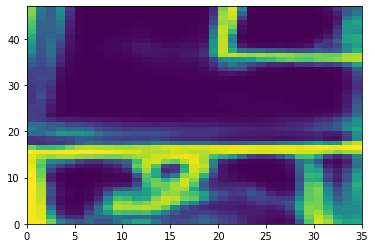

In [22]:
from matplotlib import pyplot as plt

prf_params = (0.4,0,0.1)

features = _feature_extractor(images, prf_params)

orig_size = np.array(images.shape[2:4])
downsampled_size = np.ceil(orig_size/downsample_factor).astype('int')
bbox = texture_utils.get_bbox_from_prf(prf_params, downsampled_size, n_prf_sd_out = _feature_extractor.n_prf_sd_out, min_pix=None, \
                                       verbose=False, force_square=False)
patch_size = (bbox[1] - bbox[0], bbox[3] - bbox[2])

maps = np.reshape(features.detach().cpu().numpy(), [688, patch_size[0], patch_size[1]])
plt.figure();
ind = 10
# ind = np.random.randint(0,688,1)[0]
plt.pcolormesh(maps[ind,:,:])

In [7]:
thing = np.array([2,4])
np.ceil(thing/1.5).astype('int')

array([2, 3])

In [7]:
prf_params = (0,0,0.1)

features = _feature_extractor(images, prf_params)

maps = np.reshape(features.detach().cpu().numpy(), [688, int(np.sqrt(features.shape[1])), -1])
plt.figure();
ind = 10
# ind = np.random.randint(0,688,1)[0]
plt.pcolormesh(maps[ind,:,:])

pRF [x,y,sigma]:
[0, 0, 0.1]
bbox to crop is:
[45, 108, 45, 108]
[min max] of first image patch is:
[tensor(0., device='cuda:0', dtype=torch.float64), tensor(0.8660, device='cuda:0', dtype=torch.float64)]


NameError: name 'plt' is not defined

pRF [x,y,sigma]:
[0, 0, 0.1]
bbox to crop is:
[67, 160, 67, 160]
[min max] of first image patch is:
[tensor(1.3929e-06, device='cuda:0'), tensor(0.9844, device='cuda:0')]


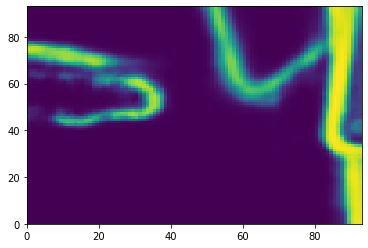

In [20]:
prf_params = (0,0,0.1)

features = _feature_extractor(images, prf_params)

maps = np.reshape(features.detach().cpu().numpy(), [688, int(np.sqrt(features.shape[1])), -1])
plt.figure();
ind = 10
# ind = np.random.randint(0,688,1)[0]
plt.pcolormesh(maps[ind,:,:])

pRF [x,y,sigma]:
[0, 0, 0.1]
bbox to crop is:
[34, 81, 34, 81]
[min max] of first image patch is:
[tensor(1.5215e-06, device='cuda:0'), tensor(0.9825, device='cuda:0')]


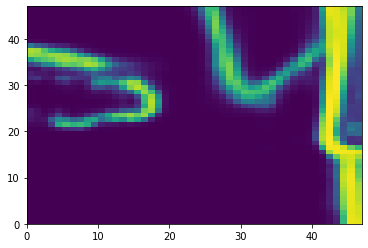

In [23]:
prf_params = (0,0,0.1)

features = _feature_extractor(images, prf_params)

maps = np.reshape(features.detach().cpu().numpy(), [688, int(np.sqrt(features.shape[1])), -1])
plt.figure();
ind = 10
# ind = np.random.randint(0,688,1)[0]
plt.pcolormesh(maps[ind,:,:])

pRF [x,y,sigma]:
[0, 0, 0.1]
bbox to crop is:
[34, 81, 34, 81]
[min max] of first image patch is:
[tensor(0., device='cuda:0', dtype=torch.float64), tensor(0.9825, device='cuda:0', dtype=torch.float64)]


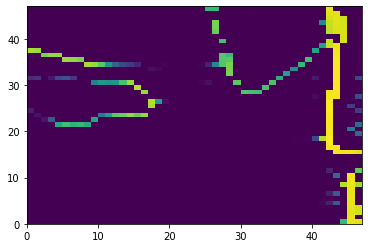

In [26]:
prf_params = (0,0,0.1)

features = _feature_extractor(images, prf_params)

maps = np.reshape(features.detach().cpu().numpy(), [688, int(np.sqrt(features.shape[1])), -1])
plt.figure();
ind = 10
# ind = np.random.randint(0,688,1)[0]
plt.pcolormesh(maps[ind,:,:])

In [48]:
_feature_extractor.fmaps.shape

torch.Size([688, 1, 227, 227])

In [59]:
maps = torch.sigmoid(_feature_extractor.fmaps)
maps_supr = apply_nms(maps[0:100])
ind = np.random.randint(0,100,1)[0]
im = images[ind,0,:,:]
E = maps[ind,0,:,:].detach().cpu().numpy()
E_supr = maps_supr[ind,0,:,:].detach().cpu().numpy()

In [38]:
torch.is_tensor(maps)

True

In [41]:
isinstance(maps, np.ndarray)

False

In [20]:
def sigmoid(x):    
    return 1/(1+np.exp(-x))

In [62]:
maps = sigmoid(_feature_extractor.fmaps.detach().cpu().numpy())
maps_supr = apply_nms(maps[0:100])
ind = np.random.randint(0,100,1)[0]
im = images[ind,0,:,:]
E = maps[ind,0,:,:]
E_supr = maps_supr[ind,0,:,:]

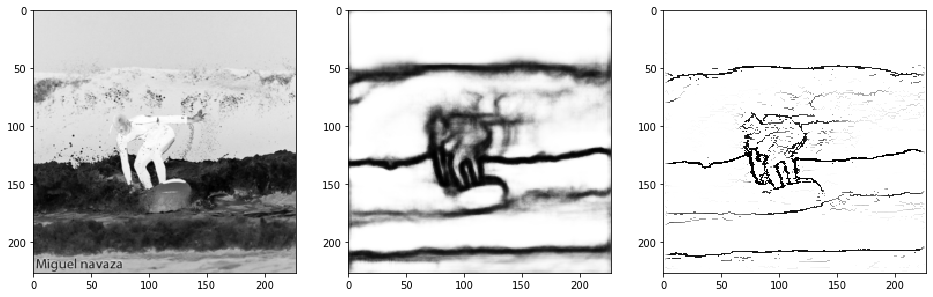

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16));

plt.subplot(1,3,1)
plt.pcolormesh(im, cmap='gray_r')
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,3,2)
plt.pcolormesh(E, cmap='gray_r')
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,3,3)
plt.pcolormesh(E_supr,cmap ='gray_r')
# plt.colorbar()
plt.axis('square')
plt.gca().invert_yaxis()


In [17]:
_feature_extractor.fmaps.shape

features = _feature_extractor(images, prf_params)

features.shape

pRF [x,y,sigma]:
[0, 0, 0.04]
bbox to crop is:
[94, 133, 94, 133]
[min max] of first image patch is:
[tensor(3.3014e-07, device='cuda:0'), tensor(0.3882, device='cuda:0')]


torch.Size([688, 1521])

In [30]:
with torch.no_grad():

    c = CannyFilter(device=device)
    im_blurred, im_grad_x, im_grad_y, im_grad_magnitude, im_grad_orientation, im_thin_edges = c(torch.tensor(images).to(device))
    
    edg_blurred, edg_grad_x, edg_grad_y, edg_grad_magnitude, edg_grad_orientation, edg_thin_edges = c(_feature_extractor.fmaps)

In [31]:
# thin edges

directional = c.directional_filter(im_grad_magnitude)
# get indices of positive and negative directions
positive_idx = (im_grad_orientation / 45) % 8
negative_idx = ((im_grad_orientation / 45) + 4) % 8
# thin_edges = im_grad_magnitude.clone()
thin_edges = torch.sigmoid(_feature_extractor.fmaps).clone()
# non maximum suppression direction by direction
for pos_i in range(4):
    neg_i = pos_i + 4
    # get the oriented grad for the angle
    is_oriented_i = (positive_idx == pos_i) * 1
    is_oriented_i = is_oriented_i + (positive_idx == neg_i) * 1
    pos_directional = directional[:, pos_i]
    neg_directional = directional[:, neg_i]
    selected_direction = torch.stack([pos_directional, neg_directional])

    # get the local maximum pixels for the angle
    is_max = selected_direction.min(dim=0)[0] > 0.0
    is_max = torch.unsqueeze(is_max, dim=1)

    # apply non maximum suppression
    to_remove = (is_max == 0) * 1 * (is_oriented_i) > 0
    thin_edges[to_remove] = 0.0
#     thin_edges[to_remove] = -100

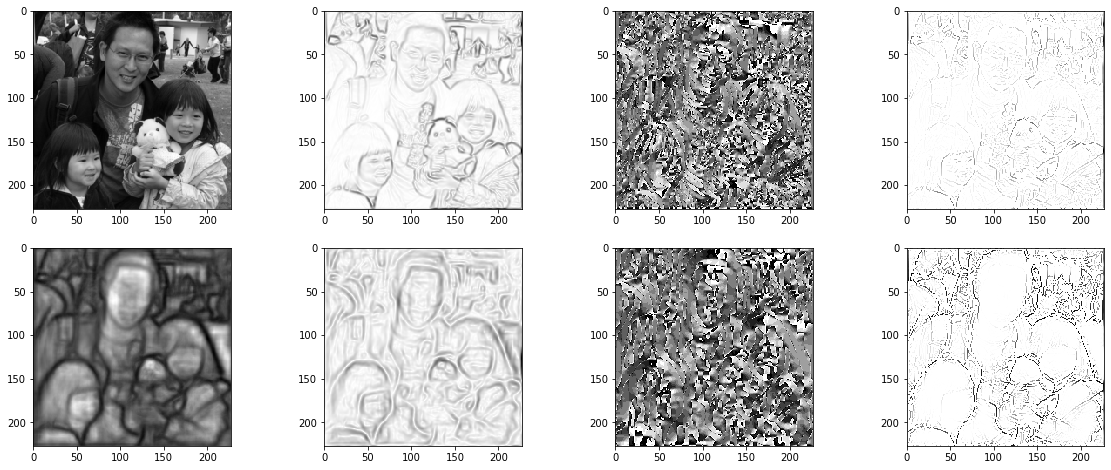

In [32]:

maps = _feature_extractor.fmaps.detach().cpu().numpy()

mag1 = im_grad_magnitude.detach().cpu().numpy()
mag2 = edg_grad_magnitude.detach().cpu().numpy()

or1 = im_grad_orientation.detach().cpu().numpy()
or2 = edg_grad_orientation.detach().cpu().numpy()


thin_maps1 = im_thin_edges.detach().cpu().numpy()
# thin_maps2 = edg_thin_edges.detach().cpu().numpy()
thin_maps2 = thin_edges.detach().cpu().numpy()

plt.figure(figsize=(20,8));

npx = 2
npy = 4
plt.subplot(npx,npy,1)
plt.pcolormesh(images[0,0,:,:],cmap='gray')
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(npx,npy,2)
plt.pcolormesh(mag1[0,0,:,:],cmap='gray_r')
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(npx,npy,3)
plt.pcolormesh(or1[0,0,:,:],cmap='gray_r')
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(npx,npy,4)
plt.pcolormesh(thin_maps1[0,0,:,:],cmap='gray_r')
plt.axis('square')
plt.gca().invert_yaxis()


plt.subplot(npx,npy,5)
plt.pcolormesh(maps[0,0,:,:],cmap='gray_r')
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(npx,npy,6)
plt.pcolormesh(mag2[0,0,:,:],cmap='gray_r')
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(npx,npy,7)
plt.pcolormesh(or2[0,0,:,:],cmap='gray_r')
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(npx,npy,8)
plt.pcolormesh(thin_maps2[0,0,:,:],cmap='gray_r')
plt.axis('square')
plt.gca().invert_yaxis()

In [33]:

def sigmoid(x):
    
    return 1/(1+np.exp(-x))

[0, 251]


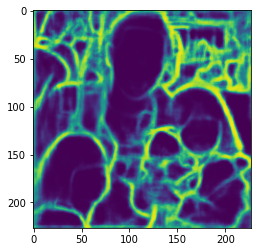

In [34]:

import PIL.Image
ex_edge_map = np.copy(maps[0,0,:,:])
ex_edge_map = sigmoid(ex_edge_map)
ex_edge_map = (ex_edge_map*255).astype(np.uint8)

print([np.min(ex_edge_map), np.max(ex_edge_map)])

im = PIL.Image.fromarray(ex_edge_map)
plt.figure()
plt.imshow(im)

im.save('test_edges.jpg')

In [35]:
im_thinned = PIL.Image.open('../../../toolboxes/thin_edges.jpg')
im_thinned = np.reshape(im_thinned.getdata(), [227,227])

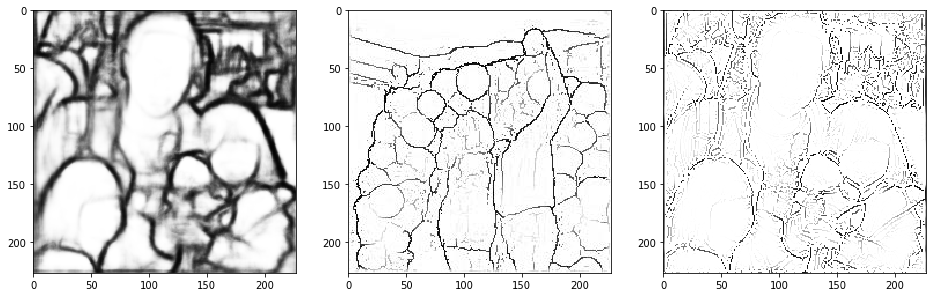

In [36]:
plt.figure(figsize=(16,16));

plt.subplot(1,3,1)
plt.pcolormesh(im, cmap='gray_r')
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,3,2)
plt.pcolormesh(im_thinned,cmap ='gray_r')
# plt.colorbar()
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,3,3)
plt.pcolormesh(thin_maps2[0,0,:,:],cmap='gray_r')
plt.axis('square')
plt.gca().invert_yaxis()

In [37]:
E = (ex_edge_map).astype('float64')
[Ox, Oy] = gradient(conv_tri(E, 4))
[Oxx, _] = gradient(Ox)
[Oxy, Oyy] = gradient(Oy)
O = np.mod(np.arctan(Oyy * np.sign(-Oxy)/(Oxx+1e-5)), np.pi)
E_supr = non_maximum_supr(E, O, 1, 5, 1.01)

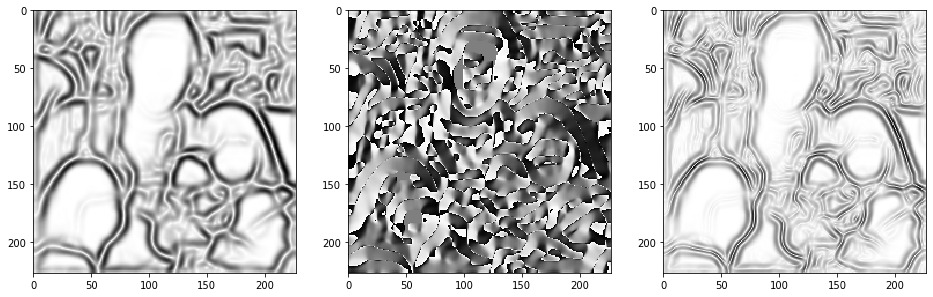

In [38]:
plt.figure(figsize=(16,16));

plt.subplot(1,3,1)
plt.pcolormesh(Ox, cmap='gray_r')
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,3,2)
plt.pcolormesh(Oy,cmap ='gray_r')
# plt.colorbar()
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,3,3)
plt.pcolormesh(Oxx,cmap ='gray_r')
# plt.colorbar()
plt.axis('square')
plt.gca().invert_yaxis()

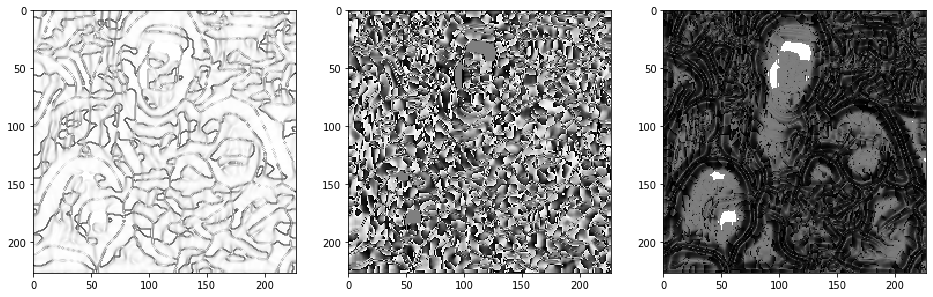

In [39]:
plt.figure(figsize=(16,16));

plt.subplot(1,3,1)
plt.pcolormesh(Oxy, cmap='gray_r')
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,3,2)
plt.pcolormesh(Oyy,cmap ='gray_r')
# plt.colorbar()
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,3,3)
plt.pcolormesh(O,cmap ='gray_r')
# plt.colorbar()
plt.axis('square')
plt.gca().invert_yaxis()

ValueError: not enough values to unpack (expected 2, got 0)

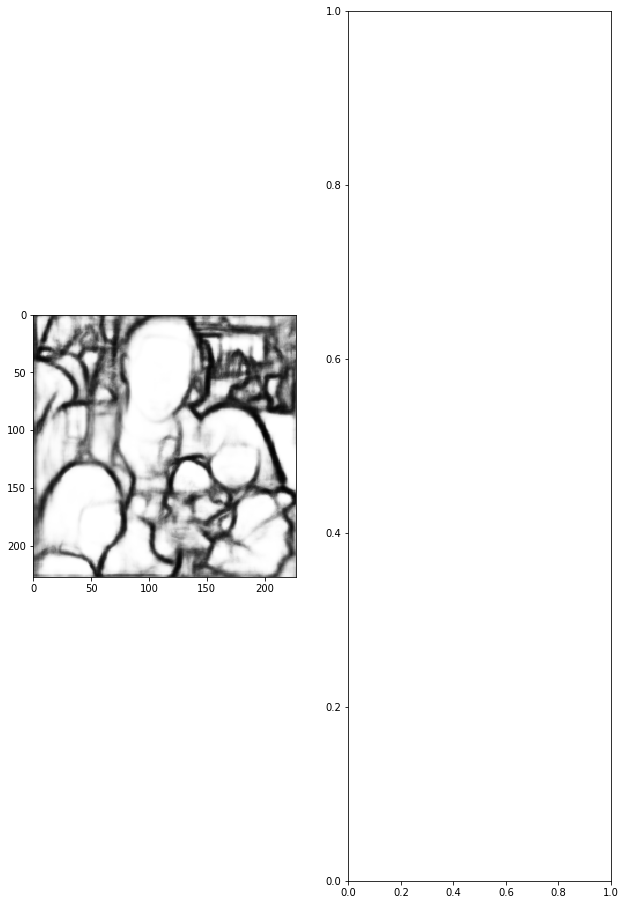

In [44]:
plt.figure(figsize=(16,16));

plt.subplot(1,3,1)
plt.pcolormesh(E, cmap='gray_r')
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,3,2)
plt.pcolormesh(E_supr,cmap ='gray_r')
# plt.colorbar()
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,3,3)
plt.pcolormesh(im_thinned,cmap ='gray_r')
# plt.colorbar()
plt.axis('square')
plt.gca().invert_yaxis()

In [100]:
E

array([[ 74.,  73.,  59., ...,  85., 108., 123.],
       [ 58.,  50.,  37., ...,  69.,  84.,  98.],
       [ 45.,  30.,  11., ...,  55.,  68.,  67.],
       ...,
       [ 29.,   8.,   3., ..., 162., 159., 148.],
       [ 29.,  10.,   4., ..., 165., 161., 146.],
       [ 28.,  10.,   4., ..., 142., 133., 123.]])

In [43]:
E_supr = apply_nms(E);

In [91]:
non_maximum_supr

<function _StructuredForests.non_maximum_supr>

In [55]:
src = E
radius = 4
radius = int(radius)
kernel = list(range(1, radius + 1)) + [radius + 1] + list(range(radius, 0, -1))
kernel = np.asarray(kernel, dtype=np.float64) / (radius + 1) ** 2

cv2.sepFilter2D(src, ddepth=-1, kernelX=kernel, kernelY=kernel,
                               borderType=cv2.BORDER_REFLECT).shape

(227, 227)

In [29]:
sys.path.append(os.path)

0

In [4]:

# from StructuredForests.utils import conv_tri, gradient
# from StructuredForests import _StructuredForests

In [30]:
with torch.no_grad():

    c = CannyFilter(device=device)
    im_blurred, im_grad_x, im_grad_y, im_grad_magnitude, im_grad_orientation, im_thin_edges = c(torch.tensor(images).to(device))
    
    edg_blurred, edg_grad_x, edg_grad_y, edg_grad_magnitude, edg_grad_orientation, edg_thin_edges = c(_feature_extractor.fmaps)

In [27]:
class CannyFilter(nn.Module):
    def __init__(self,
                 k_gaussian=3,
                 mu=0,
                 sigma=1,
                 k_sobel=3,
                 device='cpu'):
        super(CannyFilter, self).__init__()
        # device
        self.device = device

        # gaussian

        gaussian_2D = get_gaussian_kernel(k_gaussian, mu, sigma)
        self.gaussian_filter = nn.Conv2d(in_channels=1,
                                         out_channels=1,
                                         kernel_size=k_gaussian,
                                         padding=k_gaussian // 2,
                                         bias=False)
        self.gaussian_filter.to(self.device)
        self.gaussian_filter.weight[:] = torch.from_numpy(gaussian_2D)

        # sobel

        sobel_2D = get_sobel_kernel(k_sobel)
        self.sobel_filter_x = nn.Conv2d(in_channels=1,
                                        out_channels=1,
                                        kernel_size=k_sobel,
                                        padding=k_sobel // 2,
                                        bias=False)
        self.sobel_filter_x.to(self.device)
        self.sobel_filter_x.weight[:] = torch.from_numpy(sobel_2D)


        self.sobel_filter_y = nn.Conv2d(in_channels=1,
                                        out_channels=1,
                                        kernel_size=k_sobel,
                                        padding=k_sobel // 2,
                                        bias=False)
        self.sobel_filter_y.to(self.device)
        self.sobel_filter_y.weight[:] = torch.from_numpy(sobel_2D.T)


        # thin

        thin_kernels = get_thin_kernels()
        directional_kernels = np.stack(thin_kernels)

        self.directional_filter = nn.Conv2d(in_channels=1,
                                            out_channels=8,
                                            kernel_size=thin_kernels[0].shape,
                                            padding=thin_kernels[0].shape[-1] // 2,
                                            bias=False)
        self.directional_filter.to(self.device)
        self.directional_filter.weight[:, 0] = torch.from_numpy(directional_kernels)

        # hysteresis

        hysteresis = np.ones((3, 3)) + 0.25
        self.hysteresis = nn.Conv2d(in_channels=1,
                                    out_channels=1,
                                    kernel_size=3,
                                    padding=1,
                                    bias=False)
        self.hysteresis.to(self.device)
        self.hysteresis.weight[:] = torch.from_numpy(hysteresis)


    def forward(self, img, low_threshold=None, high_threshold=None, hysteresis=False):
        # set the setps tensors
        B, C, H, W = img.shape
        blurred = torch.zeros((B, C, H, W)).to(self.device)
        grad_x = torch.zeros((B, 1, H, W)).to(self.device)
        grad_y = torch.zeros((B, 1, H, W)).to(self.device)
        grad_magnitude = torch.zeros((B, 1, H, W)).to(self.device)
        grad_orientation = torch.zeros((B, 1, H, W)).to(self.device)

        # gaussian

        for c in range(C):
            blurred[:, c:c+1] = self.gaussian_filter(img[:, c:c+1])

            grad_x = grad_x + self.sobel_filter_x(blurred[:, c:c+1])
            grad_y = grad_y + self.sobel_filter_y(blurred[:, c:c+1])

        # thick edges

        grad_x, grad_y = grad_x / C, grad_y / C
        grad_magnitude = (grad_x ** 2 + grad_y ** 2) ** 0.5
        grad_orientation = torch.atan(grad_y / grad_x)
        grad_orientation = grad_orientation * (360 / np.pi) + 180 # convert to degree
        grad_orientation = torch.round(grad_orientation / 45) * 45  # keep a split by 45

        # thin edges

        directional = self.directional_filter(grad_magnitude)
        # get indices of positive and negative directions
        positive_idx = (grad_orientation / 45) % 8
        negative_idx = ((grad_orientation / 45) + 4) % 8
        thin_edges = grad_magnitude.clone()
        # non maximum suppression direction by direction
        for pos_i in range(4):
            neg_i = pos_i + 4
            # get the oriented grad for the angle
            is_oriented_i = (positive_idx == pos_i) * 1
            is_oriented_i = is_oriented_i + (positive_idx == neg_i) * 1
            pos_directional = directional[:, pos_i]
            neg_directional = directional[:, neg_i]
            selected_direction = torch.stack([pos_directional, neg_directional])

            # get the local maximum pixels for the angle
            is_max = selected_direction.min(dim=0)[0] > 0.0
            is_max = torch.unsqueeze(is_max, dim=1)

            # apply non maximum suppression
            to_remove = (is_max == 0) * 1 * (is_oriented_i) > 0
            thin_edges[to_remove] = 0.0

        # thresholds

        if low_threshold is not None:
            low = thin_edges > low_threshold

            if high_threshold is not None:
                high = thin_edges > high_threshold
                # get black/gray/white only
                thin_edges = low * 0.5 + high * 0.5

                if hysteresis:
                    # get weaks and check if they are high or not
                    weak = (thin_edges == 0.5) * 1
                    weak_is_high = (self.hysteresis(thin_edges) > 1) * weak
                    thin_edges = high * 1 + weak_is_high * 1
            else:
                thin_edges = low * 1


        return blurred, grad_x, grad_y, grad_magnitude, grad_orientation, thin_edges

In [29]:
import cv2

def get_gaussian_kernel(k=3, mu=0, sigma=1, normalize=True):
    # compute 1 dimension gaussian
    gaussian_1D = np.linspace(-1, 1, k)
    # compute a grid distance from center
    x, y = np.meshgrid(gaussian_1D, gaussian_1D)
    distance = (x ** 2 + y ** 2) ** 0.5

    # compute the 2 dimension gaussian
    gaussian_2D = np.exp(-(distance - mu) ** 2 / (2 * sigma ** 2))
    gaussian_2D = gaussian_2D / (2 * np.pi *sigma **2)

    # normalize part (mathematically)
    if normalize:
        gaussian_2D = gaussian_2D / np.sum(gaussian_2D)
    return gaussian_2D


def get_sobel_kernel(k=3):
    # get range
    range = np.linspace(-(k // 2), k // 2, k)
    # compute a grid the numerator and the axis-distances
    x, y = np.meshgrid(range, range)
    sobel_2D_numerator = x
    sobel_2D_denominator = (x ** 2 + y ** 2)
    sobel_2D_denominator[:, k // 2] = 1  # avoid division by zero
    sobel_2D = sobel_2D_numerator / sobel_2D_denominator
    return sobel_2D

def get_thin_kernels(start=0, end=360, step=45):
    k_thin = 3  # actual size of the directional kernel
    # increase for a while to avoid interpolation when rotating
    k_increased = k_thin + 2

    # get 0° angle directional kernel
    thin_kernel_0 = np.zeros((k_increased, k_increased))
    thin_kernel_0[k_increased // 2, k_increased // 2] = 1
    thin_kernel_0[k_increased // 2, k_increased // 2 + 1:] = -1

    # rotate the 0° angle directional kernel to get the other ones
    thin_kernels = []
    for angle in range(start, end, step):
        (h, w) = thin_kernel_0.shape
        # get the center to not rotate around the (0, 0) coord point
        center = (w // 2, h // 2)
        # apply rotation
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
        kernel_angle_increased = cv2.warpAffine(thin_kernel_0, rotation_matrix, (w, h), cv2.INTER_NEAREST)

        # get the k=3 kerne
        kernel_angle = kernel_angle_increased[1:-1, 1:-1]
        is_diag = (abs(kernel_angle) == 1)      # because of the interpolation
        kernel_angle = kernel_angle * is_diag   # because of the interpolation
        thin_kernels.append(kernel_angle)
    return thin_kernels
